# Calculs des coûts

Chargement de module utile pour la suite

In [1]:
import pandas as pd                      # pour gerer les tableaux de données comme excel
import numpy as np                       # pour les calculs sur des données matricielles
import matplotlib.pyplot as plt          # pour les traces
import matplotlib.ticker as tck          # pour le formateage de labels
from scipy.interpolate import interp1d,UnivariateSpline   # pour l'interpolation du rendement pondere

In [2]:
# chargement du module specifique
import os
import sys
sys.path.insert(0, os.path.abspath('../common'))
# pour la lecture et l'interpolation de la colline donnée
from module_turbine_data import CollineModeleClass, plot_transient

## Constantes physiques

* L'accélération gravitationnelle `g` en m$^2$/s$^2$ donnée par le client.
* La température de l'eau `theta` en °C donnée par le client.

In [3]:
g = 9.8105
theta = 10 # degree celsius

* Le bief aval de l'ìnstallation est à une élévation d'environ 80m. On peut donc supposer la pression atmosphérique à $p_{atm} = 10^5$ Pa à l'aval. La pression absolue en tenant compte de la chute nette énoncée plus tard sera de l'ordre de 6 à 7 bar. 
* La masse volumique de l'eau `rho` est considérée comme constante dans toute la suite. Elle est estimée à l'aide du tableau B.2 de la norme CEI 60193 pour la temperature de 10°C et la pression absolue attendue (par interpolation linéaire entre 999.7 et 1000.1 kg/m$^3$)

In [4]:
p_atm = 1.0e5
rho = 999.7 + (1000.1-999.7)/(10e5-1e5)*(6e5-1.0e5)
print('rho={0:.1f} kg/m3'.format(rho))

rho=999.9 kg/m3


* La pression de vapeur saturante $p_{va}$ de l'eau est calculée selon la formule 2.5.3.4 de la norme CEI  
\begin{align}
p_{va}\left(\theta\right) = 10^{2.7862+0.0312 \theta -0.000104\theta^2}
\end{align}

In [5]:
p_va = 10**(2.7862+0.0312 *theta -0.000104*theta**2)
print('p_va = {0:.3f} Pa (±7 Pa)'.format(p_va))

p_va = 1224.052 Pa (±7 Pa)


* La viscosité cinématique de l'eau $\nu$ est calculée selon la formule 2.5.3.3 de la norme CEI  
\begin{align}
\nu\left(\theta\right) = e^{-16.921+\frac{396.13}{107.41+\theta}}
\end{align}

In [6]:
nu = np.exp(-16.921+396.13/(107.41+theta))
print('nu = {0:.3e} m2/s2'.format(nu))

nu = 1.308e-06 m2/s2


## Données du problème

* Puissance électrique `P_e` en Watt pour une unité
* Rendement de l'alternateur `eta_alt`
* Rendement hydraulique `eta_h`
* Facteur de puissance `P_ED`
* Chutte nominale `H` en mètre

In [7]:
P_e = 150e6
eta_alt = 98.4/100.
P_ED = 0.9
H = 60.0
Hmax = 63.0
Hmin = 50.0 

* Puissance mécanique $P_m$ (notée `P_m`) correspond à la puissance à l'arbre pour l'énergie hydraulique $P_h=\rho g H Q $ disponible. Les rendements électrique (de l'alternateur) $\eta_{alt}$ et hydraulique $\eta_h$ relient les differentes puissances.
\begin{align}
\eta_{alt} &= \frac{P_e}{P_m}\\
\eta_{h} &= \frac{P_m}{P_h}
\end{align}

In [8]:
P_m = P_e / eta_alt
print('P_m = {0:.2f} MW'.format(P_m/1e6))

P_m = 152.44 MW


## Pondération du rendement
La pondération du rendement nous permet de choisir le point de rendement maximum (sommet de la colline) au point qui a le plus de poids dans l'évaluation par le client. Le client souhaite que sa machine fonctionne produise la plupart du temps entre 81 et 83 % de la puissance nominale maximum notée $P_m$. Ainsi dans le calcul du rendement pondéré, le poids de 40% est appliqué au rendement à 82% de $P_m$

In [9]:
ponderation = pd.DataFrame({'% P_m': [100,90,82,70,60],'Poids': [10,20,40,20,10]})
ponderation['Puissance [W]'] = ponderation['% P_m']/100 * P_m
ponderation

,% P_m,Poids,Puissance [W]
0,100,10,1.524390e+08
1,90,20,1.371951e+08
2,82,40,1.250000e+08
3,70,20,1.067073e+08
4,60,10,9.146341e+07


## Données du turbinier

Chemin vers le fichier excel contenant les donnees turbinier `input_excel_colline` (mis à jour le 27 Mars 2020). Les données correspondent à des données de performances sur un modèle dont le diamètre a été rapporté à 1 m au nombre de Reynolds de $7\times10^6$. Dans la suite, l'indice M correspondra à des données liées au modèle (par distinction aux données du prototype).

In [10]:
input_excel_colline = os.path.abspath('../common/data_project.xlsx')
Re_M = 7.0e6
# on cree une instance de la classe CollineModele qui sera utilisee pour l'interpolation
colline_modele = CollineModeleClass(input_excel_colline,Re_M,convert_to_m3s=True)

### Fonctions d'interpolation

Création des fonction d'interpolation $Q_{11}=f_{Q}\left(\gamma,n_{11}\right)$ et $\eta_{h,M} = f_{\eta}\left(\gamma,n_{11}\right)$.

Système $Q_{11}$, $N_{11}$ respectivement en $m^3/s$ et en rpm.
\begin{align}
Q_{11} & = \frac{Q}{D^2 \sqrt{H}}\\
N_{11} & = \frac{n_{rpm} D}{\sqrt{H}}
\end{align}

In [11]:
colline_modele.interpol_colline(spline_order=2,smoothing=0.01)
colline_modele.interpol_max_colline(spline_order=1)

[0.0, 40.0]
[60.0, 145.0]


## Prise de charge à la chute nominale
Selection du point $N_{11}$ pour la prise de charge et choix d'un diamètre $D$ pour le dimensionnement. Le $N_{11}$ sera corrigé pour obtenir une vitesse synchrone.

In [12]:
n11 = 76.0
D = 6.0

In [13]:
# help(CollineModeleClass.prise_charge)

La fonction `prise_charge` permet d'obtenir le fonctionnement de la turbine à la chute nominale. Sur les données de la colline, la prise de charge correspond à la verticale bleue. On interpole le rendement aux points de pondérations si la puissance nominale est atteignable. Les points interpolés sont représentés par des carrés rouges. 

Nombre de poles: 37
eta_M_max = 93.620 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.466 %
Majoration du rendement calculee
d_eta_maj_pm=1.701 %
Vitesse synchrone: 97.30 rpm


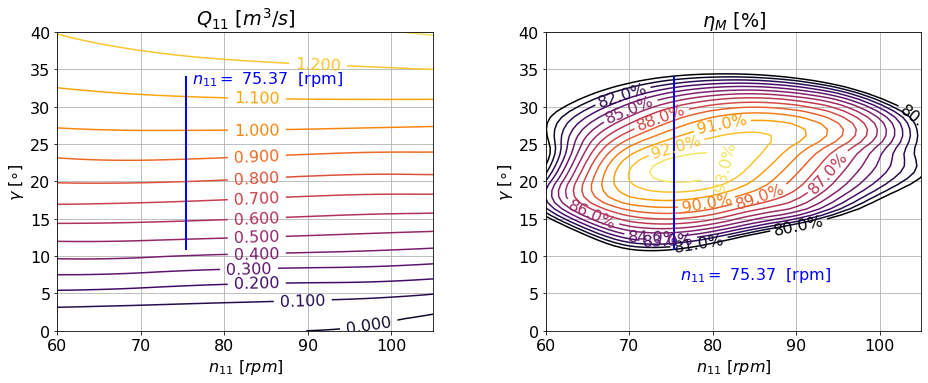

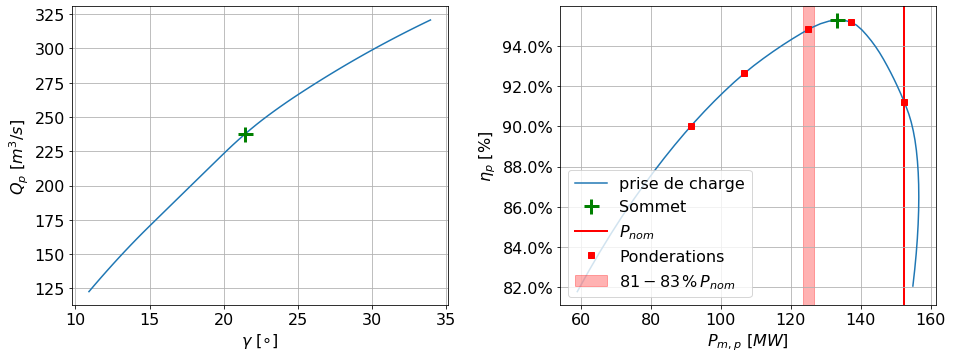

In [14]:
n_rpm_sync,d_eta_maj_pm,gamma_pc,Q_pc,eta_P_pc,P_mp_pc,fig,ax,fig2,ax2 = colline_modele.prise_charge(
    n11,D,rho,g,H,nu,npts_intp=100,flag_plot=True)
print('Vitesse synchrone: {0:.2f} rpm'.format(n_rpm_sync))
# Ajout de la puissance nominale et de la zone de ponderation maximum
ax2[1].axvline(P_m/1.0e6,color='red',linewidth=2.0,label=r'$P_{nom}$',zorder=0)
ax2[1].axvspan(0.81*P_m/1.0e6,0.83*P_m/1.0e6,color='red',alpha=0.3,label=r'$81-83\,\% \,P_{nom}$',zorder=1)
# Interpolation des rendements (si puissance nominale atteignable)
if P_mp_pc.max()>P_m: 
    # Intervale restreint pour avoir une fonction bijective
    ipmax =  P_mp_pc.argmax()
    fpe = interp1d(P_mp_pc[:ipmax+1],eta_P_pc[:ipmax+1],kind='cubic')
    # On choisit une spline d'ordre 2
    sple = UnivariateSpline(P_mp_pc[:ipmax+1],eta_P_pc[:ipmax+1],k=2,s=0) 
    ponderation['Eta [-]'] = sple(ponderation['Puissance [W]'])
    # Ajout des points de ponderation sur la courbe de rendement
    ax2[1].plot(ponderation['Puissance [W]']/1.0e6,ponderation['Eta [-]'],'s',
                color='red',label=r'Ponderations',zorder=10)
else:
    print('Puissance nominale non atteignable');
    
plt.legend(loc='lower left');
plt.show();

Calcul du rendement pondéré et tableau des valeurs interpolées

In [15]:
eta_p_weighted = np.sum(ponderation['Eta [-]']*ponderation['Poids'])/100.
print('Rendement pondéré: {0:.3f} %'.format(eta_p_weighted*100))
ponderation

Rendement pondéré: 93.618 %


,% P_m,Poids,Puissance [W],Eta [-]
0,100,10,1.524390e+08,0.912129
1,90,20,1.371951e+08,0.951930
2,82,40,1.250000e+08,0.948266
3,70,20,1.067073e+08,0.926346
4,60,10,9.146341e+07,0.900075


Géométrie de l'unité par la similitude d'échelle de la géométrie du modèle. Il faut que les dimensions respectent les marges spécifiées par le client.

In [16]:
proto_geom = colline_modele.scale_proto_geometry(D)
proto_geom

,ID,Description,Valeur,Unite
0,A,Diamètre roue,6000.0000,mm
1,B,Hauteur du distributeur,1716.0000,mm
2,C,Distance bas aube - axe du distrituteur,2460.0000,mm
3,D,Distance axe du distrituteur - fond de l'aspi...,16338.0000,mm
4,E,Distance axe roue - sortie aspirateur,26802.0000,mm
5,F,Largeur aspirateur,19338.0000,mm
6,G,Distance axe roue - bâche rive droite *,10806.0000,mm
7,H,Distance axe roue - bâche rive gauche,7944.0000,mm
8,I,Distance axe roue - entrée bâche,8166.0000,mm
9,J,Hauteur sortie aspirateur pour calcul Ec,4398.0000,mm


### Garantie cavitation
Point 3.3.3.e du cahier des charges: bief aval minimal à la chute nominale et puissance nominale

In [17]:
Bief_aval = 83.45-0.5
Q_max_nom = P_m/(rho*g*H*float(ponderation.loc[ponderation['% P_m']==100,'Eta [-]']))

Point 3.3.3.i du cahier des charges: apparition des bulles comme critère  
D'après les données modèles on a $k_{11,bulle} = \frac{\sigma_{M,bulle}}{Q_{11}^2}=0.2049718$

In [18]:
k11_lim = 0.21

Point 3.2.b du cahier des charges

In [19]:
z0_lims = [63.15-5,63.15+5]

In [20]:
hs,z0,volume_trou = colline_modele.target_k11(k11_lim,p_atm,Bief_aval,p_va,Q_max_nom,H,rho,g)
if z0<z0_lims[0] or z0>z0_lims[1]:
    print('Point 3.2.b du cahier des charges non respecte');
else: 
    cout_civil = volume_trou * 900
    print('Volume construit: {0:.3f} m3'.format(volume_trou))
    print('Cout construction: {0:.3f} M$'.format(cout_civil/1.0e6))

Nombre de Thomas vise: 0.2177
Hauteur de sustentation necessaire hs=-2.427 m
Altitude du fond aspirateur z0=66.645 m
Volume construit: 11673.726 m3
Cout construction: 10.506 M$


### Vitesse d'emballement
On cherche la vitesse d'emballement (c'est à dire le point de rendement nul) à la chute maximum et l'ouverture nominale. On fait donc une prise de charge à la chute maximale et on détermine l'ouverture pour la puissance nominale souhaitée. On balaye alors les vitesses pour chercher le point de rendement nul.

In [21]:
n11_sync_Hmax = n_rpm_sync * D /np.sqrt(Hmax)

In [22]:
n11_sync_check,_,gamma_pc_Hmax,Q_pc_Hmax,eta_P_pc_Hmax,P_mp_pc_Hmax = colline_modele.prise_charge(
    n11_sync_Hmax,D,rho,g,Hmax,nu,npts_intp=100,flag_plot=False,d_eta_maj_pm=d_eta_maj_pm)

Nombre de poles: 37
Majoration du rendement specifiee
d_eta_maj_pm=1.701 %


In [23]:
f_gd_pw = interp1d(P_mp_pc_Hmax,gamma_pc_Hmax)
gd_Hmax_nom = f_gd_pw(P_m)

In [24]:
n11_gdcst = np.linspace(colline_modele.n11_range[0],colline_modele.n11_range[1],100)
eta_M_gdcst = colline_modele.f_eta(gd_Hmax_nom,n11_gdcst)
eta_P_gdcst = eta_M_gdcst + d_eta_maj_pm;
n11_emb = colline_modele.lsq_get_N11_from_gamma_eta(gd_Hmax_nom,0.0,100.)[0]
n_emb = n11_emb * np.sqrt(Hmax) / D
print("Vitesse d'emballement: {0:.2f} rpm".format(n_emb))
print("Ratio emballement/synchrone: {0:.2f}".format(n_emb/n_rpm_sync))

Vitesse d'emballement: 182.46 rpm
Ratio emballement/synchrone: 1.88


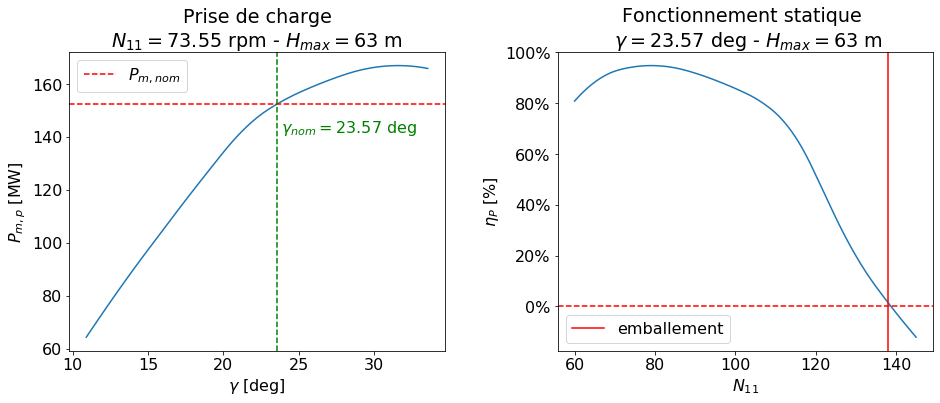

In [25]:
fig,ax = plt.subplots(1,2, figsize=(15,5))
plt.subplots_adjust(hspace=0.1,wspace = 0.3,left = 0.17,right = 0.97,bottom = 0.1,top = 0.93)
ax[0].plot(gamma_pc_Hmax,P_mp_pc_Hmax/1.0e6)
ax[0].axhline(P_m/1.0e6,color='red',label=r'$P_{m,nom}$',linestyle='--')
ax[0].axvline(gd_Hmax_nom,color='green',linestyle='--')
msg_txt = [r'$\gamma_{nom}=$','{0:.2f} deg'.format(gd_Hmax_nom)]
ax[0].text(1.01*gd_Hmax_nom,0.93*P_m/1.0e6,''.join(msg_txt),color='green')
title_txt = ['Prise de charge','\n',r'$N_{11}=$','{0:.2f} rpm'.format(n11_sync_Hmax),' - ',r'$H_{max}=$','{0:.0f} m'.format(Hmax)]
ax[0].set_title(''.join(title_txt))
ax[0].set_xlabel(r'$\gamma$ [deg]')
ax[0].legend()
ax[0].set_ylabel(r'$P_{m,p}$ [MW]');
ax[1].plot(n11_gdcst,eta_P_gdcst)
ax[1].axhline(0.0,color='red',linestyle='--')
ax[1].axvline(n11_emb,label='emballement',color='red')
title_txt = ['Fonctionnement statique',' \n ',r'$\gamma=$','{0:.2f} deg'.format(gd_Hmax_nom),' - ',r'$H_{max}=$','{0:.0f} m'.format(Hmax)]
ax[1].set_title(''.join(title_txt))
ax[1].set_xlabel(r'$N_{11}$')
ax[1].legend()
ax[1].set_ylabel(r'$\eta_{P}$ [%]');
ax[1].yaxis.set_major_formatter(tck.PercentFormatter(xmax=1.0))

### Temps de lancer
Temps $T_I$ nécessaire pour atteindre la vitesse synchrone $\Omega_s$ étant donné le couple de consigne $C_c$ et l'inertie de la roue $I$.
\begin{align}
T_I &= I \frac{\Omega_s}{C_c} \\
I &= M R_g^2
\end{align}
<font color=blue>On suppose que l'inertie pour les pièces tournantes du prototype est celle fournie dans l'énoncé. Dans les faits, la masse tournante devrait être reliée notamment au nombre de poles et le rayon de giration proportionnel au diamètre du prototype.</font>

In [26]:
I = 4e6 # kg/m^2
Om_sync = (2*np.pi * n_rpm_sync/60)
C_c = P_m / Om_sync
print('Couple de consigne: {0:.2e} N.m'.format(C_c))
T_I = I * Om_sync /C_c
print('Temps de lancer: {0:.2e} s'.format(T_I))

Couple de consigne: 1.50e+07 N.m
Temps de lancer: 2.72e+00 s


Le temps de lancer est très faible, mais il manque des données pour calibrer précisément ce temps. Cette estimation aurait pu fournir une référence pour le choix du temps caractéristique d'ouverture et fermeture des directrice en fonctionnement normal.

## Conduites forcées
Conduites de 125m de long, 7m de diamètre de limite élastique 260 MPa. Contrainte de 130 MPa max.

In [27]:
L_cf = 125
D_cf = 7
A_cf = np.pi*(D_cf/2.)**2
sigma_elastlim = 0.5*260e6

On se fixe une épaisseur il faudra vérifier qu'elle est suffisante

In [28]:
e_cf = 60e-3

### Temps caractéristique pour coup de bélier de masse
On se place à la chute maximale $H_{max}$ spécifiée par la garantie, le temps caractéristique de la conduite forcée pour un coup de bélier de masse est:
$$ T_{Bm} = \frac{L_{cf}  V_{max} }{ g  H_{max}} $$

In [29]:
Q_max = Q_pc_Hmax.max()
Vmax = Q_max/A_cf
T_Bm = L_cf * Vmax / (g * Hmax) 
print('Temps caracteristique: {0:.2f} s'.format(T_Bm))

Temps caracteristique: 1.71 s


Pour déterminer le temps de manoeuvre des directrices, on peut calculer la surpression lié à une coupure linéaire. On cherchera le temps de coupure $t_c$ qui assure que la surpression n'atteint pas la limite élastique.
\begin{align}
dh_{Bm}(t_c) &= \frac{T_{Bm}/t_c}{1-\frac{T_{Bm}}{2 t_c}}\\
H_{Bm}(t_c) &= H_{max} \left(1+dh_{Bm}(t_c)\right)
\end{align}

In [30]:
T_dir = np.arange(1.,21.)
dh_max_Bm = T_Bm/T_dir /(1-T_Bm/(2*T_dir))
pression_max_Bm = Hmax * (1+dh_max_Bm) 

On peut considérer la conduite forcée comme un cylindre mince sous pression. La contrainte est de
$\frac{p D_{cf}}{2 e_{cf}}$ où p est la pression, $e_{cf}$ est l'épaisseur de la tole choisie pour les conduites forcées.

In [31]:
sigma_Bm = pression_max_Bm * rho * g * D_cf / (2 * e_cf)

### Temps caractéristique pour coup de bélier acoustique
La vitesse du son dans la conduite (prend en compte l'élasticité de la conduite) est calculée en fonction du module de Young de l'eau $E_w$ et de la conduite $E_{cf}$ selon : 
$$c=\left[\rho \left(\frac{1}{E_w}+\frac{D_{cf}}{e_{cf}E_{cf}}\right)\right]^{-1/2}$$
Le module de Young de l'acier ASTM A516M gr.485 peut être choisi comme celui de construction [wikipedia](https://fr.wikipedia.org/wiki/Module_de_Young#Quelques_valeurs_num%C3%A9riques) et celui de l'eau (difficile à trouver) est pris de l'exercice (p. 18 cours 7)

In [32]:
Ew = 2.2e9
E_cf = 260e9
c_sound = (rho * (1/Ew + D_cf /(e_cf*E_cf)))**(-0.5)
print('Vitesse du son: {0:.2f} m/s'.format(c_sound))

Vitesse du son: 1052.23 m/s


Pour déterminer le temps de manoeuvre des directrices, on peut calculer la surpression lié à une coupure linéaire par le pic de Michaud. 
\begin{align}
dH_{Bc}(t_c) &= \frac{2 L_{cf} V_{max}}{t_c g} \\
H_{Bc}(t_c) &= H_{max} +dH_{Bc}(t_c)
\end{align}

In [33]:
dH_max_Bc = 2*L_cf * Vmax / (T_dir * g)
pression_max_Bc = Hmax + dH_max_Bc
sigma_Bc = pression_max_Bc * rho * g * D_cf / (2 * e_cf)

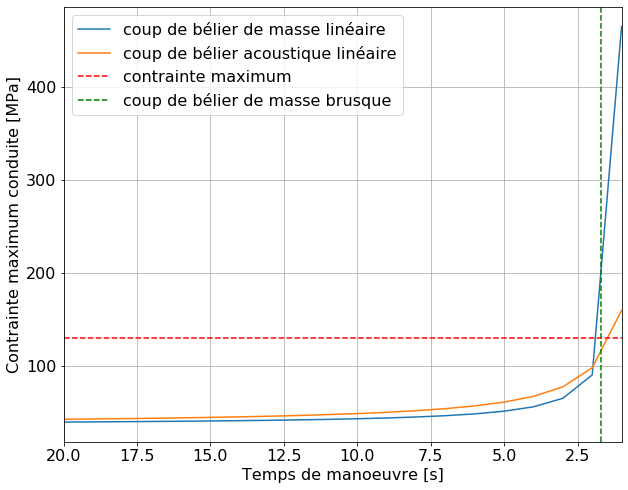

In [34]:
plt.plot(T_dir,sigma_Bm/1.0e6,label='coup de bélier de masse linéaire')
plt.plot(T_dir,sigma_Bc/1.0e6,label='coup de bélier acoustique linéaire')
plt.axhline(sigma_elastlim/1.0e6,color='red',linestyle='--',label='contrainte maximum')
plt.axvline(T_Bm,color='green',linestyle='--',label='coup de bélier de masse brusque')
plt.xlabel('Temps de manoeuvre [s]')
plt.ylabel('Contrainte maximum conduite [MPa]');
plt.xlim(T_dir.max(),T_dir.min())
plt.legend()
plt.grid()

Les deux approches permettent de s'assurer que avec l'épaisseur de 60 mm les surpressions liées aux coups de bélier à la chute max respectent la garantie.

## Transitoire avec la méthode d'Allievi
### Arrêt normal sous la chute maximale
Les estimations précédentes ne permettent pas d'obtenir un estimé de temps d'ouverture ou de fermeture. On peut choisir ce temps dans le vecteur `T_dir` entre 1 et 20 s.

In [35]:
ind_t = 10
print('Fermeture des directrices en {0:.1f} s'.format(T_dir[ind_t]))

Fermeture des directrices en 11.0 s


On suppose au temps initial un fonctionnement normal, à la puissance nominale sous la chute maximale. La minimisation du résidu est obtenu par la méthode des moindres carrés.

In [36]:
tr_norm = colline_modele.allievi_method_normal(T_dir[ind_t],Hmax,gd_Hmax_nom,n_rpm_sync,
                                               D,d_eta_maj_pm,L_cf,A_cf,rho,c_sound,g,
                                               method='SLSQP',tol=1.0e-6)

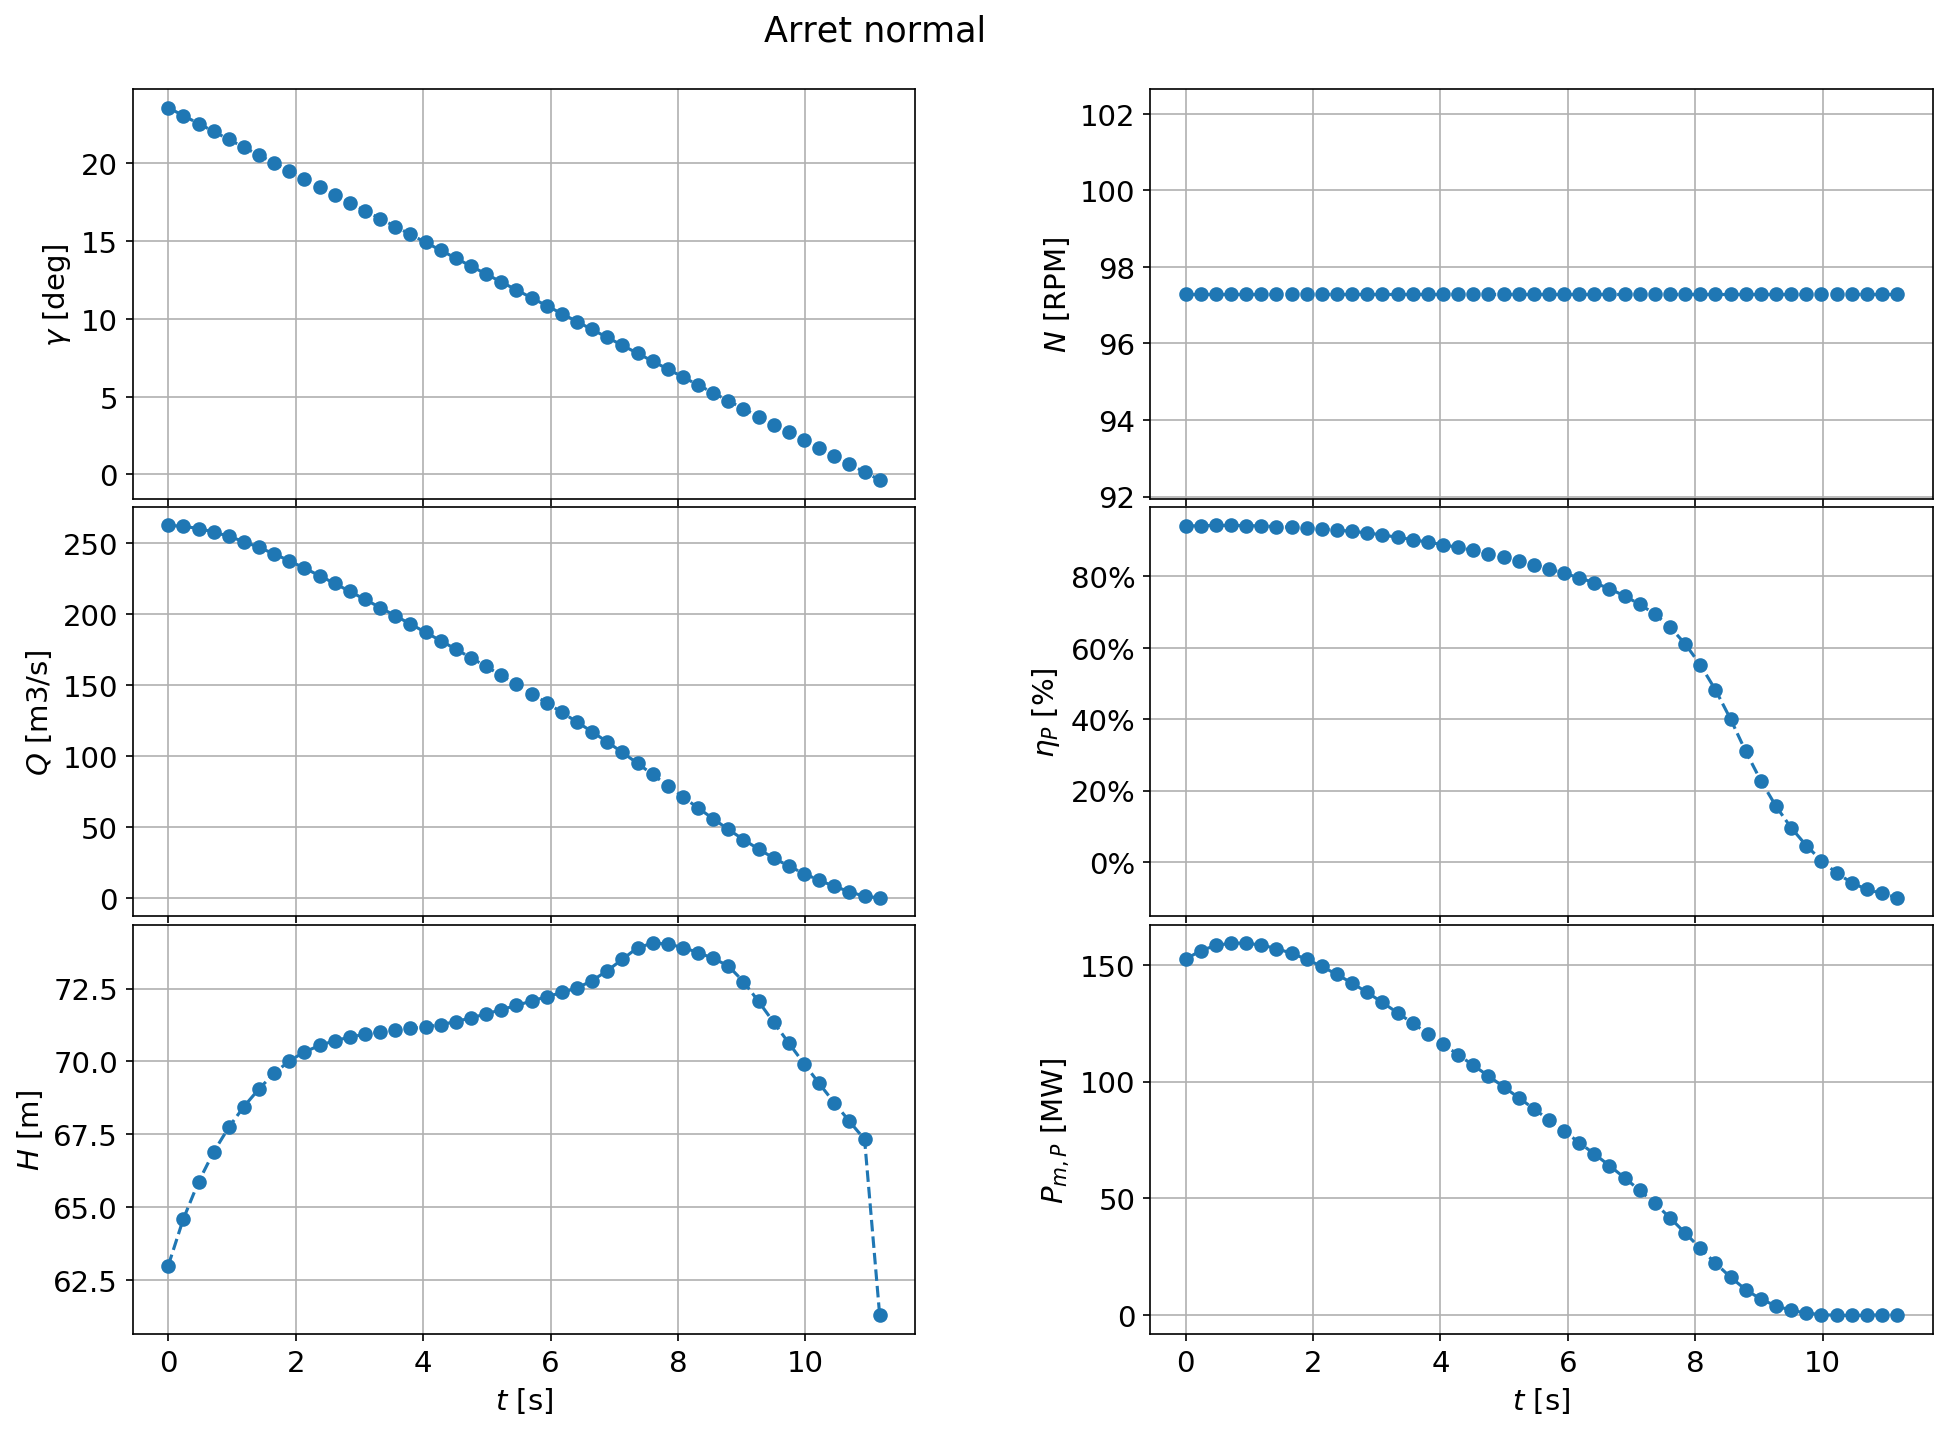

In [37]:
plot_transient(tr_norm,'Arret normal')

In [38]:
print('Fermeture directrice en {0:.1f} s'.format(T_dir[ind_t]))
print('Surpression - Coup de belier de masse {0:.2f} mce'.format(dh_max_Bm[ind_t]*Hmax))
print('Surpression - Pic de Michaud {0:.2f} mce'.format(dH_max_Bc[ind_t]))
print('Surpression - Methode d\'Allievi {0:.2f} mce'.format(tr_norm['H'].max()-Hmax))

Fermeture directrice en 11.0 s
Surpression - Coup de belier de masse 10.63 mce
Surpression - Pic de Michaud 19.61 mce
Surpression - Methode d'Allievi 11.05 mce


In [39]:
# tr_norm

Il y a comme un facteur 2 en trop dans l'expression du Pic de Michaud.

### Delestage du reseau sous la chute maximale
Les estimations précédentes ne permettent pas d'obtenir un estimé de temps d'ouverture ou de fermeture. On peut choisir ce temps dans le vecteur `T_dir` entre 1 et 20 s. Ici on prend un peu plus court car c'est une urgence et non un arrêt normal. De plus afin d'éviter les zones de la colline au rendement négatif durant l'optimisation une contrainte sur la puissance positive est imposée. Ici la méthode de *Constrained Optimization BY Linear Approximation* est celle qui fournit les résultats les plus lisses, on voit que la contrainte est active notamment à partir de 4s.

In [40]:
ind_t = 8
print('Fermeture des directrices en {0:.1f} s'.format(T_dir[ind_t]))

Fermeture des directrices en 9.0 s


In [41]:
tr_del  = colline_modele.allievi_method_delestage(T_dir[ind_t],Hmax,gd_Hmax_nom,n_rpm_sync,D,d_eta_maj_pm,I,
                                                   L_cf,A_cf,rho,c_sound,g,method='COBYLA',tol=1.0e-6)

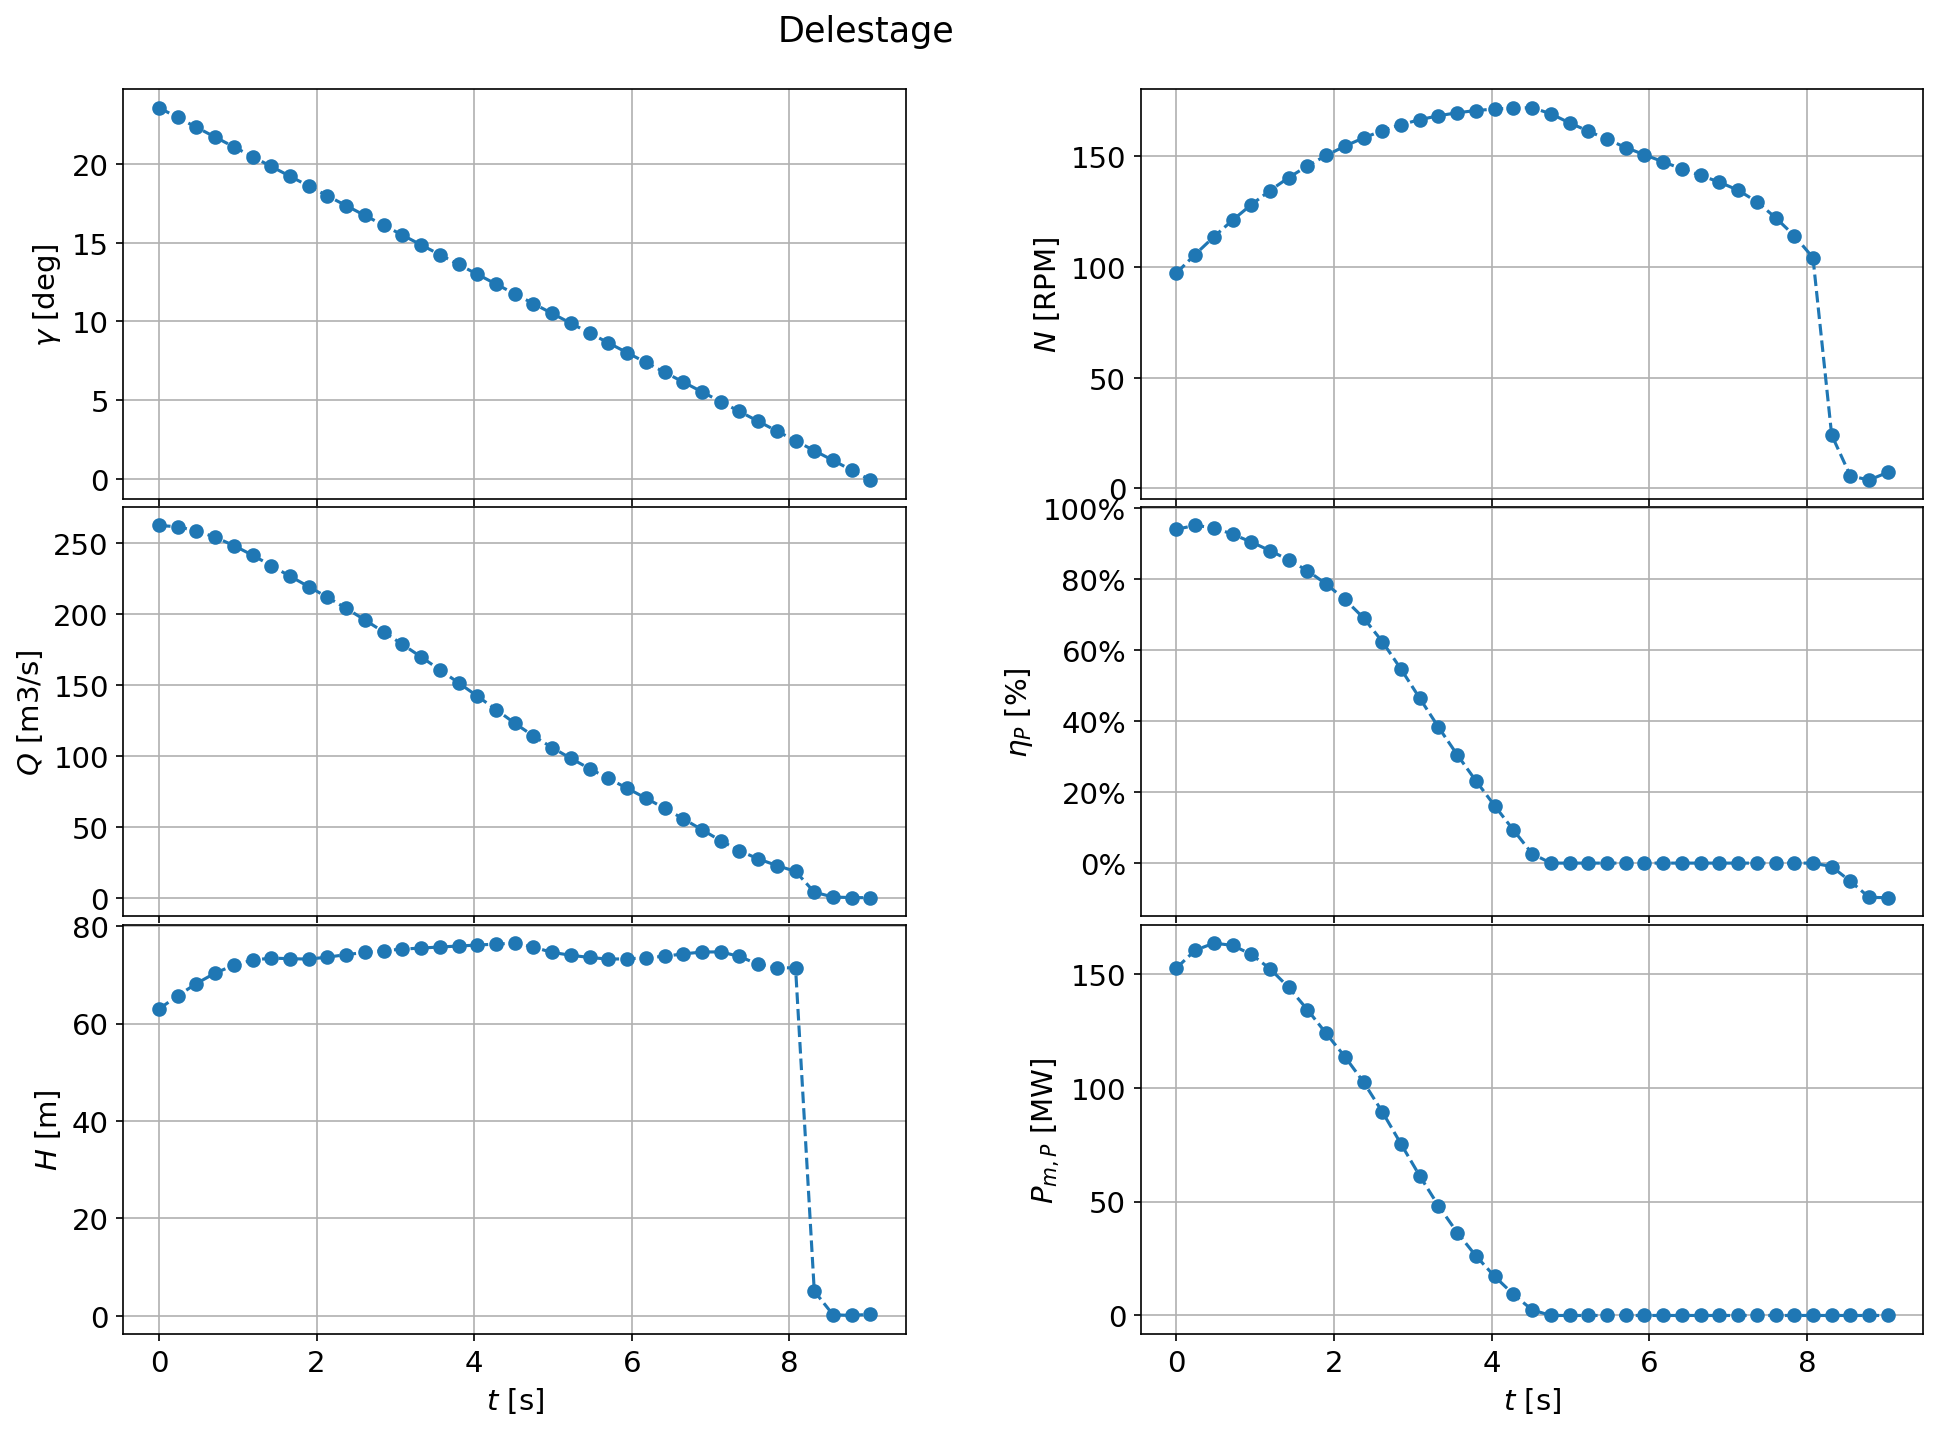

In [42]:
plot_transient(tr_del,'Delestage')

In [43]:
#tr_del

In [44]:
print('Fermeture directrice en {0:.1f} s'.format(T_dir[ind_t]))
print('Surpression - Coup de belier de masse {0:.2f} mce'.format(dh_max_Bm[ind_t]*Hmax))
print('Surpression - Pic de Michaud {0:.2f} mce'.format(dH_max_Bc[ind_t]))
print('Surpression - Methode d\'Allievi {0:.2f} mce'.format(tr_del['H'].max()-Hmax))

Fermeture directrice en 9.0 s
Surpression - Coup de belier de masse 13.25 mce
Surpression - Pic de Michaud 23.97 mce
Surpression - Methode d'Allievi 13.50 mce


### Emballement de la roue sous la chute maximale
On suppose que le couple résistif imposé par le réseau diminue. De plus afin d'éviter les zones de la colline au rendement négatif durant l'optimisation une contrainte sur la puissance positive est imposée. Ici la méthode de *Constrained Optimization BY Linear Approximation* est à nouveau utilisée.

In [45]:
ind_t = 5
print('Diminution du couple resistif en {0:.1f} s'.format(T_dir[ind_t]))

Diminution du couple resistif en 6.0 s


In [46]:
tr_emb  = colline_modele.allievi_method_emballement(T_dir[ind_t],Hmax,gd_Hmax_nom,n_rpm_sync,D,d_eta_maj_pm,I,
                                                   L_cf,A_cf,rho,c_sound,g,method='COBYLA',tol=1.0e-6)

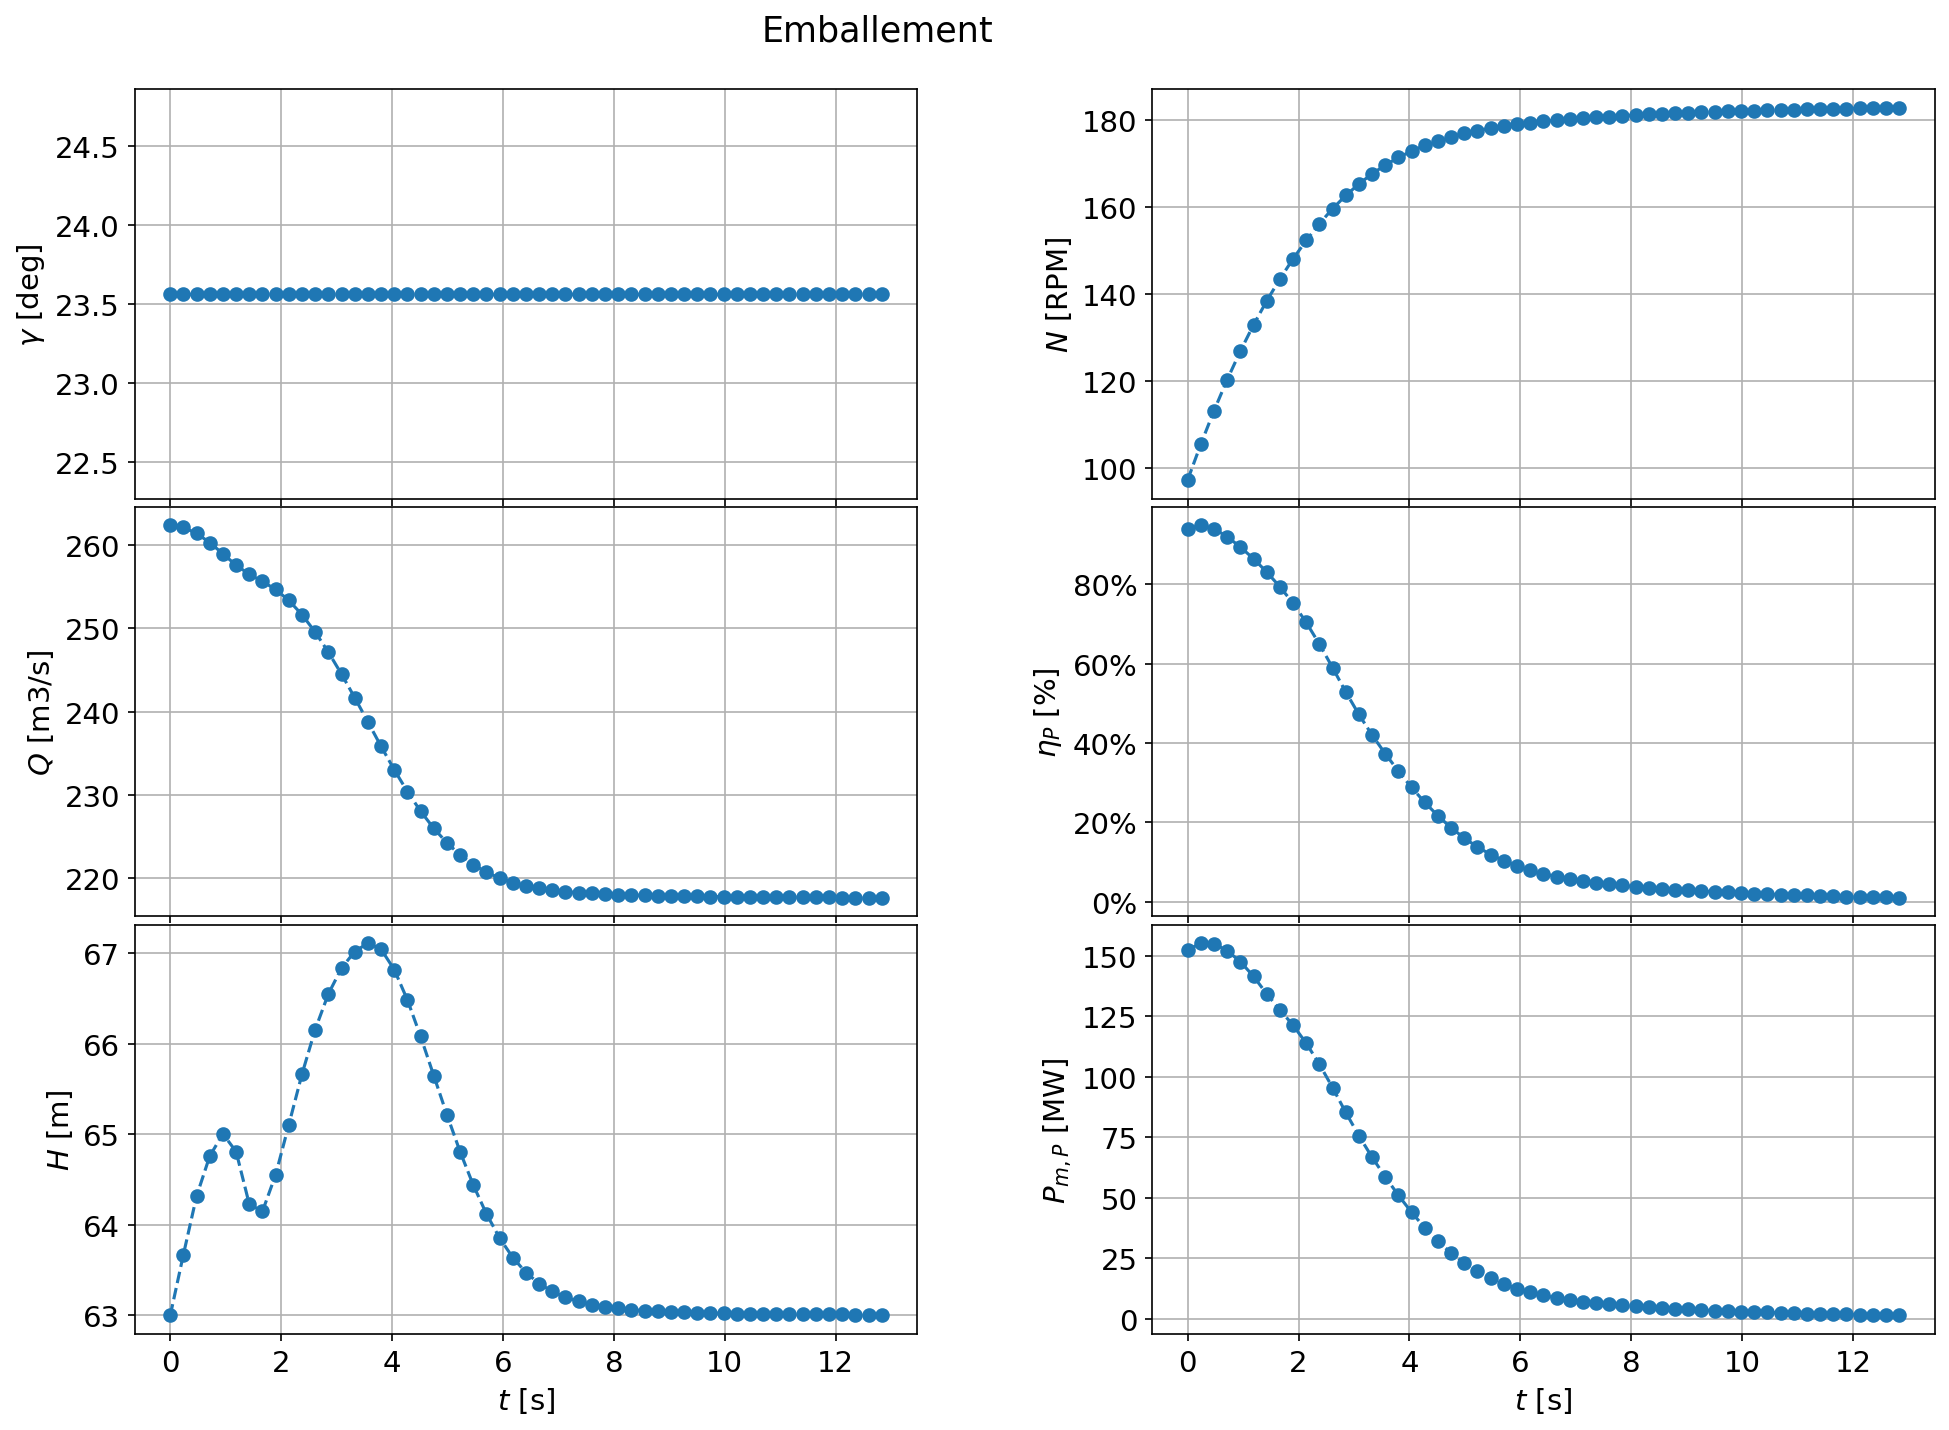

In [47]:
plot_transient(tr_emb,'Emballement')

In [48]:
print('Diminution du couple resistif en {0:.1f} s'.format(T_dir[ind_t]))
print('Surpression - Methode d\'Allievi {0:.2f} mce'.format(tr_emb['H'].max()-Hmax))
print('Vitesse d\'emballement {0:.2f} rpm'.format(tr_emb.loc[tr_emb.shape[0]-1,'n_rpm']))
print('Vitesse d\'emballement (fonctionnement statique) {0:.2f} rpm'.format(n_emb))

Diminution du couple resistif en 6.0 s
Surpression - Methode d'Allievi 4.11 mce
Vitesse d'emballement 182.90 rpm
Vitesse d'emballement (fonctionnement statique) 182.46 rpm
